# 1. Harris Corner Detector

In [3]:
import cv2
import numpy as np
from matplotlib import pyplot as plt


def harris_corner_detector(image_path, gaussian_window_size=3, alpha=0.04, threshold=0.01,
                           neighborhood_size=3, non_maximal_suppression_enable=True):
    """
    Detects corners in an image using the Harris Corner Detection method.

    Args:
        image_path (str): The path to the image file.
        gaussian_window_size (int): Size of the Gaussian filter window. Default is 3.
        alpha (float): Harris detector free parameter. Default is 0.04.
        threshold (float): Threshold for corner detection. Default is 0.01.
        neighborhood_size (int): Size of the neighborhood for non-maximal suppression. Default is 3.
        non_maximal_suppression_enable (bool): Whether to apply non-maximal suppression. Default is True.

    Returns:
        tuple: The original image with corners marked and the binary corner response image.
    """
    # Load and convert image to grayscale
    image = cv2.imread(image_path)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian smoothing
    smoothed_image = apply_gaussian_blur(gray_image, gaussian_window_size)

    # Compute gradients
    Ix, Iy = compute_image_gradients(smoothed_image)

    # Compute the Harris corner response matrix
    R = compute_harris_response(Ix, Iy, alpha, neighborhood_size)

    # Identify corners based on threshold
    corners = identify_corners(R, threshold)

    # Apply non-maximal suppression if enabled
    if non_maximal_suppression_enable:
        corners = non_maximal_suppression(corners, neighborhood_size)

    # Draw corners on the image
    image_with_corners = draw_corners_on_image(image, corners, neighborhood_size)

    return cv2.cvtColor(image_with_corners, cv2.COLOR_BGR2RGB), corners


def apply_gaussian_blur(image, gaussian_window_size):
    """
    Applies Gaussian blur to the image.

    Args:
        image (numpy.ndarray): Grayscale image to be smoothed.
        gaussian_window_size (int): Size of the Gaussian filter window.

    Returns:
        numpy.ndarray: Smoothed image.
    """
    return cv2.GaussianBlur(image, (gaussian_window_size, gaussian_window_size), 0)


def compute_image_gradients(image):
    """
    Computes the gradients of the image using the Sobel operator.

    Args:
        image (numpy.ndarray): Smoothed grayscale image.

    Returns:
        tuple: Gradients in the x and y directions (Ix, Iy).
    """
    Ix = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    Iy = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    return Ix, Iy


def compute_harris_response(Ix, Iy, alpha, neighborhood_size):
    """
    Computes the Harris corner response matrix.

    Args:
        Ix (numpy.ndarray): Gradient in the x direction.
        Iy (numpy.ndarray): Gradient in the y direction.
        alpha (float): Harris detector free parameter.
        neighborhood_size (int): Size of the neighborhood window for summation.

    Returns:
        numpy.ndarray: Harris corner response matrix R.
    """
    Ixx = Ix ** 2
    Ixy = Ix * Iy
    Iyy = Iy ** 2

    # Sum of products of derivatives at each pixel
    window = np.ones((neighborhood_size, neighborhood_size), dtype=np.float32)
    Sxx = cv2.filter2D(Ixx, -1, window)
    Sxy = cv2.filter2D(Ixy, -1, window)
    Syy = cv2.filter2D(Iyy, -1, window)

    # Determinant and trace of the Harris matrix
    det_M = (Sxx * Syy) - (Sxy ** 2)
    trace_M = Sxx + Syy

    # Harris response formula
    return det_M - alpha * (trace_M ** 2)


def identify_corners(R, threshold):
    """
    Identifies corners based on the threshold.

    Args:
        R (numpy.ndarray): Harris corner response matrix.
        threshold (float): Threshold for corner detection.

    Returns:
        numpy.ndarray: Binary image with corners marked as 255.
    """
    corners = np.zeros_like(R, dtype=np.uint8)
    corners[R > threshold * np.max(R)] = 255
    return corners


def non_maximal_suppression(corners, neighborhood_size):
    """
    Applies non-maximal suppression to the corners.

    Args:
        corners (numpy.ndarray): Binary image with initial corner detections.
        neighborhood_size (int): Size of the neighborhood for suppression.

    Returns:
        numpy.ndarray: Binary image with non-maximally suppressed corners.
    """
    half_size = neighborhood_size // 2
    suppressed_corners = np.copy(corners)

    for i in range(half_size, corners.shape[0] - half_size):
        for j in range(half_size, corners.shape[1] - half_size):
            if corners[i, j] == 255:
                window = corners[i - half_size:i + half_size + 1, j - half_size:j + half_size + 1]
                if np.max(window) != 255:
                    suppressed_corners[i, j] = 0

    return suppressed_corners


def draw_corners_on_image(image, corners, neighborhood_size):
    """
    Draws circles on the original image at detected corner locations.

    Args:
        image (numpy.ndarray): Original image.
        corners (numpy.ndarray): Binary image with corner detections.
        neighborhood_size (int): Size of the neighborhood used for corner detection.

    Returns:
        numpy.ndarray: Image with corners marked.
    """
    height, width = image.shape[:2]
    offset = neighborhood_size // 2

    for y in range(offset, height - offset):
        for x in range(offset, width - offset):
            if corners[y, x] == 255:
                cv2.circle(image, (x, y), 5, (255, 0, 0), -1)

    return image

## 1.1 Effect of Different Gaussian Window Sizes

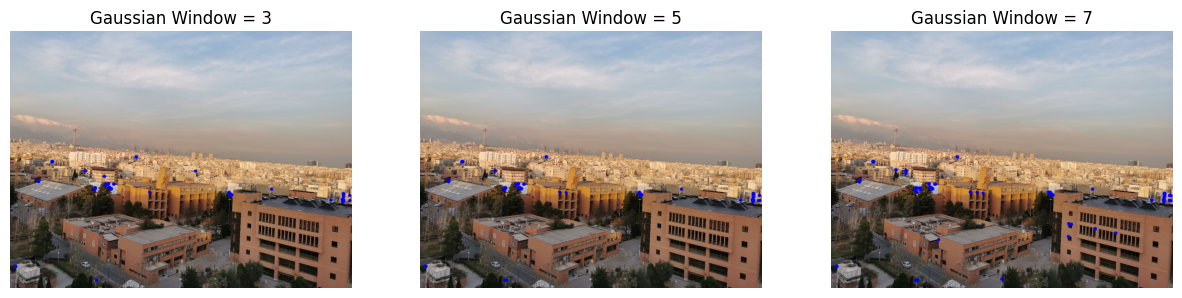

In [4]:
# Example usage: Detecting corners with different Gaussian window sizes
img_with_corners_g3, _ = harris_corner_detector("./imgs/Image1.png", gaussian_window_size=3, alpha=0.04, threshold=0.30, neighborhood_size=5)
img_with_corners_g5, _ = harris_corner_detector("./imgs/Image1.png", gaussian_window_size=5, alpha=0.04, threshold=0.30, neighborhood_size=5)
img_with_corners_g7, _ = harris_corner_detector("./imgs/Image1.png", gaussian_window_size=7, alpha=0.04, threshold=0.30, neighborhood_size=5)

# Plotting the results
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(img_with_corners_g3)
plt.title("Gaussian Window = 3")
plt.axis(False)
plt.subplot(1, 3, 2)
plt.imshow(img_with_corners_g5)
plt.title("Gaussian Window = 5")
plt.axis(False)
plt.subplot(1, 3, 3)
plt.imshow(img_with_corners_g7)
plt.title("Gaussian Window = 7")
plt.axis(False)
plt.show()

## 1.2 Effect of Different Threshold Values

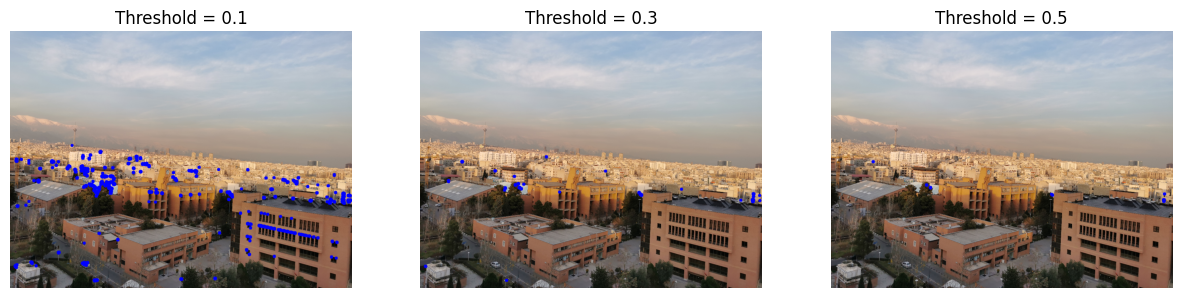

In [2]:
# Example usage: Visualize corners with different threshold values
img_with_corners_th1, _ = harris_corner_detector("./imgs/Image1.png", gaussian_window_size=3, alpha=0.04, threshold=0.10, neighborhood_size=5)
img_with_corners_th3, _ = harris_corner_detector("./imgs/Image1.png", gaussian_window_size=3, alpha=0.04, threshold=0.30, neighborhood_size=5)
img_with_corners_th5, _ = harris_corner_detector("./imgs/Image1.png", gaussian_window_size=3, alpha=0.04, threshold=0.50, neighborhood_size=5)

# Plotting the results
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(img_with_corners_th1)
plt.title("Threshold = 0.1")
plt.axis(False)
plt.subplot(1, 3, 2)
plt.imshow(img_with_corners_th3)
plt.title("Threshold = 0.3")
plt.axis(False)
plt.subplot(1, 3, 3)
plt.imshow(img_with_corners_th5)
plt.title("Threshold = 0.5")
plt.axis(False)
plt.show()

## 1.3 Effect of Non-Maximal Suppression

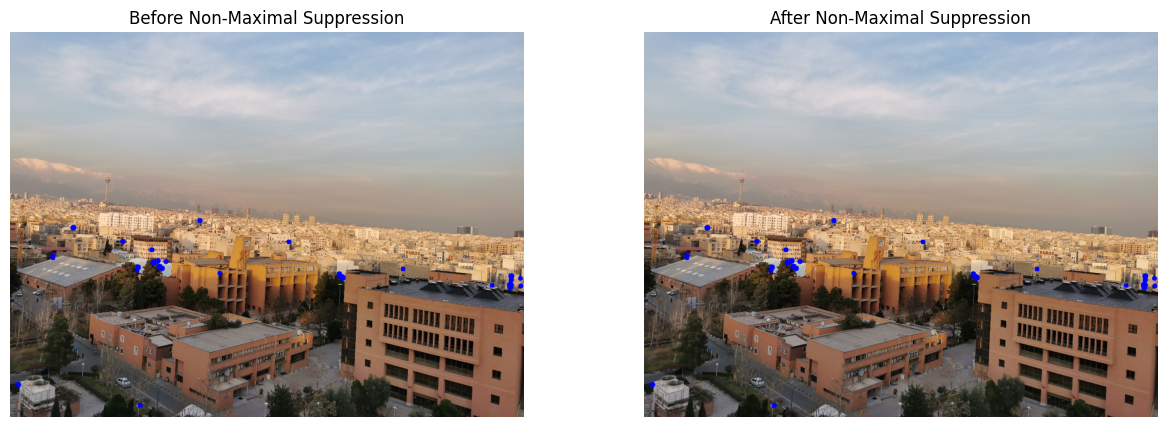

In [5]:
# Example usage: Visualize corners with and without non-maximal suppression
img_with_corners_wo_nms, _ = harris_corner_detector("./imgs/Image1.png", gaussian_window_size=3, alpha=0.04, threshold=0.30, neighborhood_size=5, non_maximal_suppression_enable=False)
img_with_corners_w_nms, _ = harris_corner_detector("./imgs/Image1.png", gaussian_window_size=3, alpha=0.04, threshold=0.30, neighborhood_size=5)

# Plotting the results
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.imshow(img_with_corners_wo_nms)
plt.title("Before Non-Maximal Suppression")
plt.axis(False)
plt.subplot(1, 2, 2)
plt.imshow(img_with_corners_w_nms)
plt.title("After Non-Maximal Suppression")
plt.axis(False)
plt.show()

# 2. RANSAC & Panorama Image

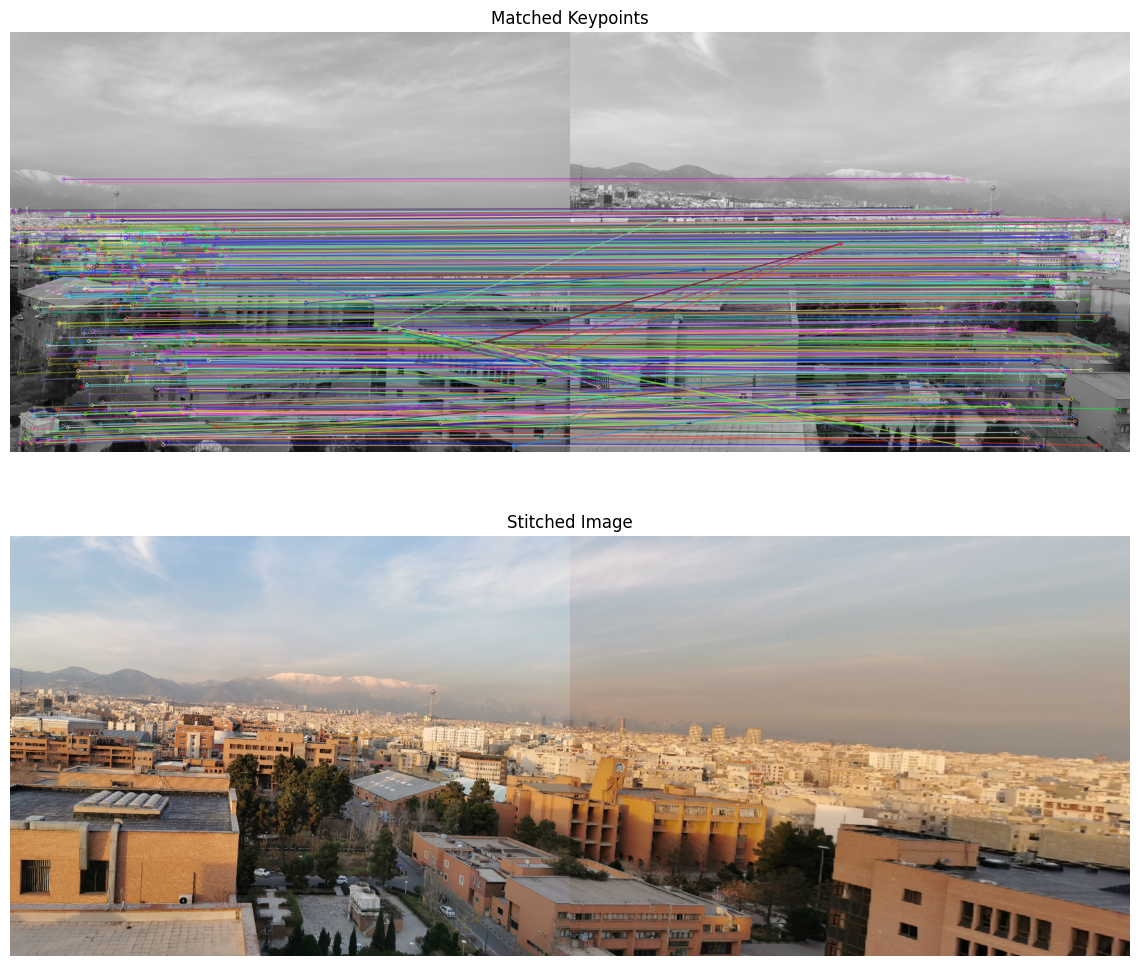

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


def draw_matches(img1, img2, kp1, kp2, matches):
    """
    Draws matches between keypoints of two images.

    Args:
        img1 (numpy.ndarray): First image.
        img2 (numpy.ndarray): Second image.
        kp1 (list): Keypoints in the first image.
        kp2 (list): Keypoints in the second image.
        matches (list): List of matched keypoints.

    Returns:
        numpy.ndarray: Image with matches drawn.
    """
    return cv2.drawMatches(
        img1, kp1,
        img2, kp2,
        matches, None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )


def sift_feature_matching(img1, img2):
    """
    Performs SIFT feature detection and matching between two images.

    Args:
        img1 (numpy.ndarray): First grayscale image.
        img2 (numpy.ndarray): Second grayscale image.

    Returns:
        tuple: Source points, destination points, and image with matches drawn.
    """
    # Initialize SIFT detector
    sift = cv2.SIFT_create()

    # Detect keypoints and compute descriptors
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    # Initialize Brute Force Matcher and match descriptors
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)

    # Apply ratio test to filter good matches
    good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]

    # Draw matches between keypoints
    matched_img = draw_matches(img1, img2, kp1, kp2, good_matches)

    # Extract matched keypoints
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    return src_pts, dst_pts, matched_img


def ransac_homography(src_pts, dst_pts, num_iterations=2000, threshold=4):
    """
    Computes the best homography matrix using RANSAC.

    Args:
        src_pts (numpy.ndarray): Source points from the first image.
        dst_pts (numpy.ndarray): Destination points from the second image.
        num_iterations (int): Number of RANSAC iterations. Default is 2000.
        threshold (float): Distance threshold to determine inliers. Default is 4.

    Returns:
        numpy.ndarray: Homography matrix.
    """
    best_H = None
    max_inliers = 0

    for _ in range(num_iterations):
        # Randomly select 4 correspondences to compute homography
        indices = np.random.choice(len(src_pts), 4, replace=False)
        src_sample = src_pts[indices]
        dst_sample = dst_pts[indices]

        # Compute homography matrix
        H, _ = cv2.findHomography(src_sample, dst_sample, cv2.RANSAC, threshold)

        # Apply homography to all points
        transformed_pts = cv2.perspectiveTransform(src_pts, H)

        # Calculate number of inliers
        distances = np.linalg.norm(transformed_pts - dst_pts, axis=2)
        inliers = np.sum(distances < threshold)

        # Update the best homography matrix if more inliers are found
        if inliers > max_inliers:
            max_inliers = inliers
            best_H = H

    return best_H


def stitch_images(img1, img2, H):
    """
    Stitches two images together using a homography matrix.

    Args:
        img1 (numpy.ndarray): First image.
        img2 (numpy.ndarray): Second image.
        H (numpy.ndarray): Homography matrix.

    Returns:
        numpy.ndarray: Stitched image.
    """
    height, width = img2.shape[:2]

    # Warp img1 to align with img2 using the homography matrix
    warped_img1 = cv2.warpPerspective(img1, H, (img1.shape[1] + width, height))
    warped_img1[:height, :width] = img2

    return warped_img1


def show_images(*images, titles=None):
    """
    Displays multiple images using matplotlib.

    Args:
        *images: Variable length image list to display.
        titles (list, optional): Titles for each subplot. Defaults to None.

    Returns:
        None
    """
    num_images = len(images)
    plt.figure(figsize=(15, 12))

    for i, image in enumerate(images):
        plt.subplot(num_images, 1, i + 1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        if titles:
            plt.title(titles[i])
        plt.axis('off')

    plt.show()


if __name__ == "__main__":
    # Load images
    img1 = cv2.imread('./imgs/Image1.png')
    img2 = cv2.imread('./imgs/Image2.png')

    # Convert images to grayscale
    gray_img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray_img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    # Extract features and matching points
    src_pts, dst_pts, matched_img = sift_feature_matching(gray_img1, gray_img2)

    # Find the best homography using RANSAC
    H = ransac_homography(src_pts, dst_pts, threshold=0.5)

    # Stitch images together
    result = stitch_images(img1, img2, H)

    # Display the matched keypoints and the final stitched image
    show_images(matched_img, result, titles=["Matched Keypoints", "Stitched Image"])
